# Homework 3

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Class Definitions (used for problems)

In [2]:
class Person:

    def __init__(self):
        self.g = None
        self.e = None
        self.p = None
        self.mz = None
        self.dz = None
        self.hs = None
    
    def __repr__(self):
        try:
            return f'Person, g: {str(round(self.g, 3))}, e: {str(round(self.e, 3))}'
        except:
            return 'Person Object'
    
    def simulate_traits(self, h2):
        va = h2
        ve = 1 - h2
        self.g = np.random.normal(loc = 0.0, scale = np.sqrt(va))
        self.e = np.random.normal(loc = 0.0, scale = np.sqrt(ve))
        self.p = self.g + self.e
    
    def genetic_transmission(self, par1, par2, h2):
        '''Problem 1a'''
        self.par1 = par1
        self.par2 = par2

        va = h2
        ve = 1 - h2
        self.g = np.random.normal(loc = 0.5*(self.par1.g + self.par2.g), scale = np.sqrt(va/2))
        try:
            self.p = self.g + self.e
        except:
            pass
    
    def genetic_transmission_from_sibling(self, sibling):
        '''Problem 1a'''
        self.g = sibling.g
        try:
            self.p = self.g + self.e
        except:
            pass
    
    def environment_transmission(self, h2):
        va = h2
        ve = 1 - h2

        shared_e = np.random.normal(loc = 0.0, scale = np.sqrt(ve))

        return shared_e
    
    def environment_transmission_from_mean(self, shared_e, h2, shared_env):
        va = h2
        ve = 1 - h2

        e_not_shared = np.random.normal(loc = 0.0, scale = np.sqrt(ve))
        self.e = shared_env*shared_e + (1-shared_env)*e_not_shared
        try:
            self.p = self.g + self.e
        except:
            pass


In [3]:
class Family:

    def __init__(self, par1, par2, parent_gen, par3 = None):
        self.par_gen = parent_gen
        self.par1 = par1
        self.par2 = par2
        self.children = []
        self.children_k = 'nc'
        if par3 is not None:
            self.fullpar3 = par3

    def __repr__(self):
        return f'Family: {self.par1}, {self.par2}, {self.children}'
    
    def add_children(self, child_gen, h2, shared_gen, shared_env):
        '''Problem 1a'''
        va = h2
        ve = 1 - h2

        child1 = Person()
        child1.par1 = self.par1
        child1.par2 = self.par2
        child2 = Person()
        child2.par1 = self.par1
        child2.par2 = self.par2

        if shared_gen is True:
            child1.genetic_transmission(self.par1, self.par2, h2)
            child2.genetic_transmission_from_sibling(child1)
            self.children_k = 1
            child1.mz = child2
            child2.mz = child1
        else:
            child1.genetic_transmission(self.par1, self.par2, h2)
            child2.genetic_transmission(self.par1, self.par2, h2)
            self.children_k = 0.5
            child1.dz = child2
            child2.dz = child1
        
        shared_e = child1.environment_transmission(h2)
        child1.environment_transmission_from_mean(shared_e, h2, shared_env)
        child2.environment_transmission_from_mean(shared_e, h2, shared_env)

        self.children.append(child1)
        self.children.append(child2)
        child_gen.add_person(child1)
        child_gen.add_person(child2)

    def add_half_siblings(self, child_gen, h2, shared_env):
        va = h2
        ve = 1 - h2

        self.children_k = 0.25

        child1 = Person()
        child1.par1 = self.par1
        child1.par2 = self.fullpar3
        child2 = Person()
        child2.par1 = self.par2
        child2.par2 = self.fullpar3

        child1.hs = child2
        child2.hs = child1

        child1.genetic_transmission(child1.par1, child2.par2, h2)
        child2.genetic_transmission(child1.par1, child2.par2, h2)

        shared_e = child1.environment_transmission(h2)
        child1.environment_transmission_from_mean(shared_e, h2, shared_env)
        child2.environment_transmission_from_mean(shared_e, h2, shared_env)

        self.children.append(child1)
        self.children.append(child2)
        child_gen.add_person(child1)
        child_gen.add_person(child2)

In [4]:
class Generation:

    def __init__(self):
        self.people = []
        self.families = []

    def add_person(self, person):
        self.people.append(person)
    
    def create_mz_dz_families(self, child_gen, h2, shared_env):
        '''Problem 1a'''
        for i in range(0, len(self.people), 2):
            family = Family(self.people[i], self.people[i+1], self)
            if np.random.choice([0, 1]) == 0:
                family.add_children(child_gen, h2, shared_gen=True, shared_env=shared_env)
            else:
                family.add_children(child_gen, h2, shared_gen=False, shared_env=shared_env)
            self.families.append(family)
    
    def create_mz_dz_families_uneven(self, child_gen, h2, mz_shared_env, dz_shared_env):
        '''Problem 1a'''
        for i in range(0, len(self.people), 2):
            family = Family(self.people[i], self.people[i+1], self)
            if np.random.choice([0, 1]) == 0:
                family.add_children(child_gen, h2, shared_gen=True, shared_env=mz_shared_env)
            else:
                family.add_children(child_gen, h2, shared_gen=False, shared_env=dz_shared_env)
            self.families.append(family)
    
    def create_half_sibling_families(self, child_gen, h2, shared_env):
        '''Problem 2b'''
        for i in range(0, len(self.people), 3):
            family = Family(self.people[i], self.people[i+1], self, self.people[i+2])
            family.add_half_siblings(child_gen, h2, shared_env=shared_env)
            self.families.append(family)
    
    def plot_kinship_vs_phenotype(self, child_gen, h2):
        '''Problem 1b and 1c'''
        kinship = []
        phenotype_product = []
        for family in self.families:
            assert family.children_k != 'nc'
            kinship.append(family.children_k)
            phenotype_product.append(family.children[0].p * family.children[1].p)
        child_list = child_gen.people.copy()
        random.shuffle(child_list)
        for i in range(0, len(child_list), 2):
            child1 = child_list[i]
            child2 = child_list[i+1]

            if (child1.par1 != child2.par1) and (child1.par1 != child2.par2) and (child1.par2 != child2.par1) and (child1.par2 != child2.par2):
                kinship.append(0)
                phenotype_product.append(child1.p * child2.p)

        plt.scatter(kinship, phenotype_product)
        plt.title('Genotype Similarity vs Phenotype Similarity')
        plt.xlabel('Genotype Similarity (Kinship)')
        plt.ylabel('Phenotype Similarity (p*p)')

        # Adding true heritability line (1ci)
        plt.plot(kinship, h2*np.array(kinship), label = 'True H2 ' + str(h2), c = 'red')

        # Adding falconer's heritability estimate (1cii)
        mz_1_p = []
        mz_2_p = []
        dz_1_p = []
        dz_2_p = []

        for family in self.families:
            if family.children_k == 1: # MZ
                mz_1_p.append(family.children[0].p)
                mz_2_p.append(family.children[1].p)
            if family.children_k == 0.5: # DZ
                dz_1_p.append(family.children[0].p)
                dz_2_p.append(family.children[1].p)
        rmz = np.corrcoef(mz_1_p, mz_2_p)[0, 1]
        rdz = np.corrcoef(dz_1_p, dz_2_p)[0, 1]

        h2_f = 2*(rmz - rdz)

        plt.plot(kinship, h2_f*np.array(kinship), label = 'Falconer H2 ' + str(round(h2_f, 3)), c = 'green')
        plt.legend()

### Problem 1

In [12]:
# Problem 1a
h2 = 0.3

# simulate 1000 parents
gen1 = Generation()
for i in range(1000):
    per = Person()
    per.simulate_traits(h2)
    gen1.add_person(per)

# simulate children
gen2 = Generation()
gen1.create_mz_dz_families(gen2, h2, shared_env=0)

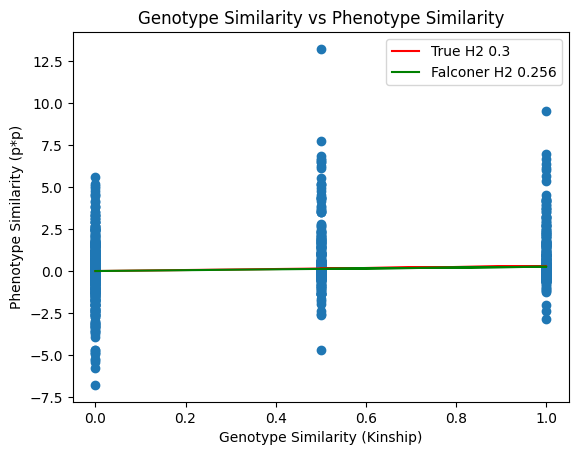

In [13]:
# Problem 1b, 1c

gen1.plot_kinship_vs_phenotype(gen2, h2)

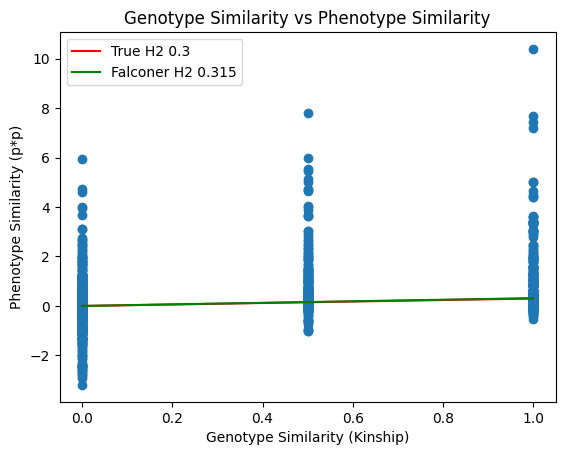

In [9]:
# Problem 1d

h2 = 0.3

# simulate 1000 parents
gen1_shared_env = Generation()
for i in range(1000):
    per = Person()
    per.simulate_traits(h2)
    gen1_shared_env.add_person(per)

# simulate children
gen2_shared_env = Generation()
gen1_shared_env.create_mz_dz_families(gen2_shared_env, h2, shared_env=0.5)

gen1_shared_env.plot_kinship_vs_phenotype(gen2_shared_env, h2)

##### Falconer's estimate still works if the MZ and DZ twins have the same amount of shared environment.

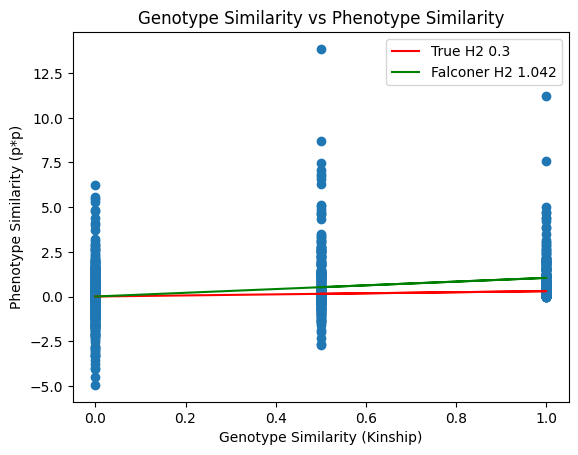

In [14]:
# Problem 1e - shared environment larger in MZ twins

h2 = 0.3

# simulate 1000 parents
gen1_mz_shared_env = Generation()
for i in range(1000):
    per = Person()
    per.simulate_traits(h2)
    gen1_mz_shared_env.add_person(per)

# simulate children
gen2_mz_shared_env = Generation()
gen1_mz_shared_env.create_mz_dz_families_uneven(gen2_mz_shared_env, h2, mz_shared_env=0.9, dz_shared_env=0)

gen1_mz_shared_env.plot_kinship_vs_phenotype(gen2_mz_shared_env, h2)

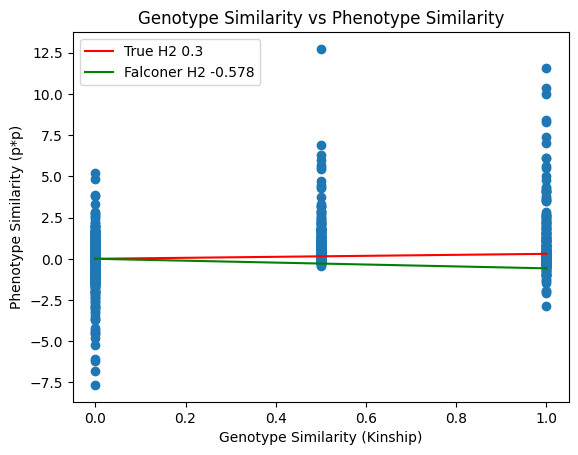

In [15]:
# Problem 1e - shared environment larger in DZ twins

h2 = 0.3

# simulate 1000 parents
gen1_mz_shared_env = Generation()
for i in range(1000):
    per = Person()
    per.simulate_traits(h2)
    gen1_mz_shared_env.add_person(per)

# simulate children
gen2_mz_shared_env = Generation()
gen1_mz_shared_env.create_mz_dz_families_uneven(gen2_mz_shared_env, h2, mz_shared_env=0, dz_shared_env=0.9)

gen1_mz_shared_env.plot_kinship_vs_phenotype(gen2_mz_shared_env, h2)

##### When the shared environment is different between the MZ and DZ twins, the falconer's estimate does not work. When DZ shared environment is bigger than MZ, falconer's estimate is smaller than the true h2. When MZ shared environment is bigger, falconer's estimate is bigger than the true h2.

### Problem 2

In [ ]:
# Problem 2a

# def he_regression(Y, K):
#     n = len(K)
#     assert n == len(Y)

#     y_list = []
#     k_list = []
#     for row in range(n):
#         for col in range(n):
#             y_list.append(Y[row, col])
#             k_list.append(K[row, col])

#     coefficients = np.polyfit(k_list, y_list, 1)
#     h2 = coefficients[0]

#     return h2


def he_regression(Y, K):
    n = len(K)
    assert Y.shape == (n, n)
    
    y_list = []
    k_list = []
    for i in range(n):
        for j in range(i+1, n):
            y_list.append(Y[i, j])
            k_list.append(K[i, j])

    coefficients = np.polyfit(k_list, y_list, 1)
    h2 = coefficients[0]

    return h2



In [65]:
# Problem 2b

h2 = 0.3

# simulate 500 twin parents
twin_parents = Generation()
for i in range(500):
    per = Person()
    per.simulate_traits(h2)
    twin_parents.add_person(per)

# simulate 500 twins (250 twin pairs)
twins = Generation()
twin_parents.create_mz_dz_families(twins, h2, shared_env=0)

# simulate 750 half sibling parents
half_sibling_parents = Generation()
for i in range(750):
    per = Person()
    per.simulate_traits(h2)
    half_sibling_parents.add_person(per)

# simulate 500 half siblings (250 half sibling pairs)
half_siblings = Generation()
half_sibling_parents.create_half_sibling_families(half_siblings, h2, shared_env=0)

# add half siblings and twins
children_gen = Generation()
for per in twins.people:
    children_gen.add_person(per)
for per in half_siblings.people:
    children_gen.add_person(per)

half_sibling_gen = Generation()
for per in enumerate(half_siblings.people):
    half_sibling_gen.add_person(per)

twins_gen = Generation()
for per in twins.people:
    twins_gen.add_person(per)


In [66]:
# Problem 2c

# N by N kinship matrix (N = 1000)
K = np.zeros((1000, 1000))
for row, child1 in enumerate(children_gen.people):
    for col, child2 in enumerate(children_gen.people):
        if child1 == child2 or child1.mz == child2:
            K[row, col] = 1
        elif child1.hs == child2:
            K[row, col] = 0.25
        elif child1.dz == child2:
            K[row, col] = 0.5

# phenotypic similarity matrix
Y = np.zeros((1000, 1000))
for row, child1 in enumerate(children_gen.people):
    for col, child2 in enumerate(children_gen.people):
        Y[row, col] = child1.p * child2.p


# N by N kinship matrix (N = 1000)
K_mz_dz = np.zeros((500, 500))
for row, child1 in enumerate(twins.people):
    for col, child2 in enumerate(twins.people):
        if child1 == child2 or child1.mz == child2:
            K_mz_dz[row, col] = 1
        elif child1.hs == child2:
            K_mz_dz[row, col] = 0.25
        elif child1.dz == child2:
            K_mz_dz[row, col] = 0.5

# phenotypic similarity matrix
Y_mz_dz = np.zeros((500, 500))
for row, child1 in enumerate(twins.people):
    for col, child2 in enumerate(twins.people):
        Y_mz_dz[row, col] = child1.p * child2.p


# N by N kinship matrix (N = 1000)
K_hs = np.zeros((500, 500))
for row, child1 in enumerate(half_siblings.people):
    for col, child2 in enumerate(half_siblings.people):
        if child1 == child2 or child1.mz == child2:
            K_hs[row, col] = 1
        elif child1.hs == child2:
            K_hs[row, col] = 0.25
        elif child1.dz == child2:
            K_hs[row, col] = 0.5

# phenotypic similarity matrix
Y_hs = np.zeros((500, 500))
for row, child1 in enumerate(half_siblings.people):
    for col, child2 in enumerate(half_siblings.people):
        Y_hs[row, col] = child1.p * child2.p

n = 1000

y_list = []
k_list = []
for row in range(n):
    for col in range(n):
        y_list.append(Y[row, col])
        k_list.append(K[row, col])

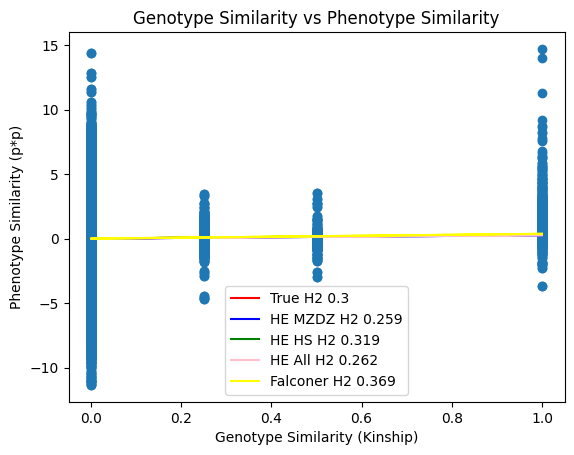

In [67]:
plt.scatter(k_list, y_list)
plt.title('Genotype Similarity vs Phenotype Similarity')
plt.xlabel('Genotype Similarity (Kinship)')
plt.ylabel('Phenotype Similarity (p*p)')

# Problem 2d

# true H2
plt.plot(k_list, h2*np.array(k_list), label = 'True H2 ' + str(h2), c = 'red')

# HE based on MZ and DZ twins
h2_estimate_mz_dz = he_regression(Y_mz_dz, K_mz_dz)
plt.plot(k_list, h2_estimate_mz_dz*np.array(k_list), label = 'HE MZDZ H2 ' + str(round(h2_estimate_mz_dz, 3)), c = 'blue')

# HE based on half siblings
h2_estimate_hs = he_regression(Y_hs, K_hs)
plt.plot(k_list, h2_estimate_hs*np.array(k_list), label = 'HE HS H2 ' + str(round(h2_estimate_hs, 3)), c = 'green')

# HE based on all
h2_estimate = he_regression(Y, K)
plt.plot(k_list, h2_estimate*np.array(k_list), label = 'HE All H2 ' + str(round(h2_estimate, 3)), c = 'pink')

# Falconer's estimate
mz_1_p = []
mz_2_p = []
dz_1_p = []
dz_2_p = []
for family in twin_parents.families:
    if family.children_k == 1: # MZ
        mz_1_p.append(family.children[0].p)
        mz_2_p.append(family.children[1].p)
    if family.children_k == 0.5: # DZ
        dz_1_p.append(family.children[0].p)
        dz_2_p.append(family.children[1].p)
rmz = np.corrcoef(mz_1_p, mz_2_p)[0, 1]
rdz = np.corrcoef(dz_1_p, dz_2_p)[0, 1]
h2_f = 2*(rmz - rdz)
plt.plot(k_list, h2_f*np.array(k_list), label = 'Falconer H2 ' + str(round(h2_f, 3)), c = 'yellow')

plt.legend()

In [68]:
# Problem 2e

h2 = 0.3

# simulate 500 twin parents
twin_parents = Generation()
for i in range(500):
    per = Person()
    per.simulate_traits(h2)
    twin_parents.add_person(per)

# simulate 500 twins (250 twin pairs)
twins = Generation()
twin_parents.create_mz_dz_families(twins, h2, shared_env=0.5)

# simulate 750 half sibling parents
half_sibling_parents = Generation()
for i in range(750):
    per = Person()
    per.simulate_traits(h2)
    half_sibling_parents.add_person(per)

# simulate 500 half siblings (250 half sibling pairs)
half_siblings = Generation()
half_sibling_parents.create_half_sibling_families(half_siblings, h2, shared_env=0.5)

# add half siblings and twins
children_gen = Generation()
for per in twins.people:
    children_gen.add_person(per)
for per in half_siblings.people:
    children_gen.add_person(per)

half_sibling_gen = Generation()
for per in enumerate(half_siblings.people):
    half_sibling_gen.add_person(per)

twins_gen = Generation()
for per in twins.people:
    twins_gen.add_person(per)

In [ ]:
# N by N kinship matrix (N = 1000)
K = np.zeros((1000, 1000))
for row, child1 in enumerate(children_gen.people):
    for col, child2 in enumerate(children_gen.people):
        if child1 == child2 or child1.mz == child2:
            K[row, col] = 1
        elif child1.hs == child2:
            K[row, col] = 0.25
        elif child1.dz == child2:
            K[row, col] = 0.5

# phenotypic similarity matrix
Y = np.zeros((1000, 1000))
for row, child1 in enumerate(children_gen.people):
    for col, child2 in enumerate(children_gen.people):
        Y[row, col] = child1.p * child2.p


# N by N kinship matrix (N = 1000)
K_mz_dz = np.zeros((500, 500))
for row, child1 in enumerate(twins.people):
    for col, child2 in enumerate(twins.people):
        if child1 == child2 or child1.mz == child2:
            K_mz_dz[row, col] = 1
        elif child1.hs == child2:
            K_mz_dz[row, col] = 0.25
        elif child1.dz == child2:
            K_mz_dz[row, col] = 0.5

# phenotypic similarity matrix
Y_mz_dz = np.zeros((500, 500))
for row, child1 in enumerate(twins.people):
    for col, child2 in enumerate(twins.people):
        Y_mz_dz[row, col] = child1.p * child2.p


# N by N kinship matrix (N = 1000)
K_hs = np.zeros((500, 500))
for row, child1 in enumerate(half_siblings.people):
    for col, child2 in enumerate(half_siblings.people):
        if child1 == child2 or child1.mz == child2:
            K_hs[row, col] = 1
        elif child1.hs == child2:
            K_hs[row, col] = 0.25
        elif child1.dz == child2:
            K_hs[row, col] = 0.5

# phenotypic similarity matrix
Y_hs = np.zeros((500, 500))
for row, child1 in enumerate(half_siblings.people):
    for col, child2 in enumerate(half_siblings.people):
        Y_hs[row, col] = child1.p * child2.p

n = 1000

y_list = []
k_list = []
for row in range(n):
    for col in range(n):
        y_list.append(Y[row, col])
        k_list.append(K[row, col])

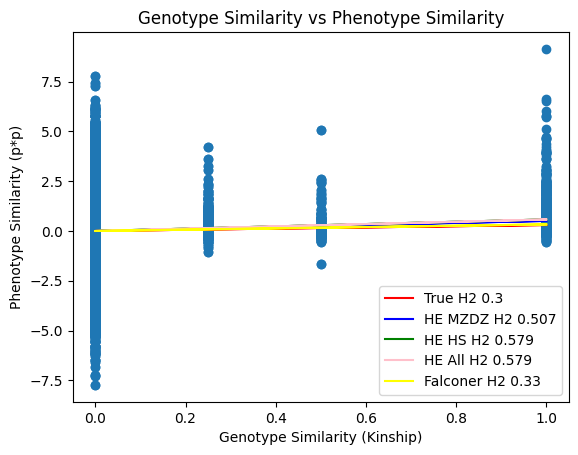

In [71]:
plt.scatter(k_list, y_list)
plt.title('Genotype Similarity vs Phenotype Similarity')
plt.xlabel('Genotype Similarity (Kinship)')
plt.ylabel('Phenotype Similarity (p*p)')

# true H2
plt.plot(k_list, h2*np.array(k_list), label = 'True H2 ' + str(h2), c = 'red')

# HE based on MZ and DZ twins
h2_estimate_mz_dz = he_regression(Y_mz_dz, K_mz_dz)
plt.plot(k_list, h2_estimate_mz_dz*np.array(k_list), label = 'HE MZDZ H2 ' + str(round(h2_estimate_mz_dz, 3)), c = 'blue')

# HE based on half siblings
h2_estimate_hs = he_regression(Y, K)
plt.plot(k_list, h2_estimate_hs*np.array(k_list), label = 'HE HS H2 ' + str(round(h2_estimate_hs, 3)), c = 'green')

# HE based on all
h2_estimate = he_regression(Y, K)
plt.plot(k_list, h2_estimate*np.array(k_list), label = 'HE All H2 ' + str(round(h2_estimate, 3)), c = 'pink')

# Falconer's estimate
mz_1_p = []
mz_2_p = []
dz_1_p = []
dz_2_p = []
for family in twin_parents.families:
    if family.children_k == 1: # MZ
        mz_1_p.append(family.children[0].p)
        mz_2_p.append(family.children[1].p)
    if family.children_k == 0.5: # DZ
        dz_1_p.append(family.children[0].p)
        dz_2_p.append(family.children[1].p)
rmz = np.corrcoef(mz_1_p, mz_2_p)[0, 1]
rdz = np.corrcoef(dz_1_p, dz_2_p)[0, 1]
h2_f = 2*(rmz - rdz)
plt.plot(k_list, h2_f*np.array(k_list), label = 'Falconer H2 ' + str(round(h2_f, 3)), c = 'yellow')

plt.legend()

In [15]:
# Problem 2f
def he_regression_optimized(Y, K):
    # Extract the upper triangle (excluding the diagonal)
    i_upper = np.triu_indices_from(K, k=1)
    
    k_vals = K[i_upper]
    y_vals = Y[i_upper]

    # Use NumPy to fit a line (regress y on k)
    h2 = np.polyfit(k_vals, y_vals, 1)[0]
    
    return h2

def five_runs_per_h2(h2):
    for run in range(5):
        print('starting new run')
        parent_gen = Generation()
        for i in range(2000):
            per = Person()
            per.simulate_traits(h2)
            parent_gen.add_person(per)

        children_gen = Generation()
        parent_gen.create_mz_dz_families(children_gen, h2, shared_env=0)

        # print('creating kinship matrix')
        # # N by N kinship matrix (N = 10000)
        # K = np.zeros((10000, 10000))
        # for row, child1 in enumerate(children_gen.people):
        #     for col, child2 in enumerate(children_gen.people):
        #         if child1 == child2 or child1.mz == child2:
        #             K[row, col] = 1
        #         elif child1.hs == child2:
        #             K[row, col] = 0.25
        #         elif child1.dz == child2:
        #             K[row, col] = 0.5

        # # phenotypic similarity matrix
        # Y = np.zeros((10000, 10000))
        # for row, child1 in enumerate(children_gen.people):
        #     for col, child2 in enumerate(children_gen.people):
        #         Y[row, col] = child1.p * child2.p


        N = len(children_gen.people)

        # Precompute phenotype vector
        phenotypes = np.array([child.p for child in children_gen.people])

        # Initialize kinship matrix
        K = np.zeros((N, N))

        # Precompute relationship groups
        mz_pairs = []
        dz_pairs = []
        hs_pairs = []

        index_lookup = {child: idx for idx, child in enumerate(children_gen.people)}

        for i, child1 in enumerate(children_gen.people):
            if child1.mz and child1.mz in index_lookup:
                j = index_lookup[child1.mz]
                if i < j:
                    mz_pairs.append((i, j))
            if child1.dz and child1.dz in index_lookup:
                j = index_lookup[child1.dz]
                if i < j:
                    dz_pairs.append((i, j))
            if child1.hs and child1.hs in index_lookup:
                j = index_lookup[child1.hs]
                if i < j:
                    hs_pairs.append((i, j))

        for i, j in mz_pairs:
            K[i, j] = K[j, i] = 1
        for i, j in dz_pairs:
            K[i, j] = K[j, i] = 0.5
        for i, j in hs_pairs:
            K[i, j] = K[j, i] = 0.25

        np.fill_diagonal(K, 1)

        Y = np.outer(phenotypes, phenotypes)
        
        # print('getting info to plot')
        # n = 10000
        # y_list = []
        # k_list = []
        # for row in range(n):
        #     for col in range(n):
        #         y_list.append(Y[row, col])
        #         k_list.append(K[row, col])
        
        # plt.scatter(k_list, y_list)

        # print('regressing')
        # h2_estimate = he_regression(Y, K)
        # plt.plot(k_list, h2_estimate*np.array(k_list), c = 'pink')

        # I ran out of memory trying to run N = 10K, so I'm doing 2K instead
        n = 2000
        y_list = Y[np.triu_indices(n, k=1)]
        k_list = K[np.triu_indices(n, k=1)]

        plt.scatter(k_list, y_list)

        h2_estimate = he_regression_optimized(Y, K)
        plt.plot(k_list, h2_estimate * k_list, c='pink', label = 'Run ' + str(run) + ' ' + str(round(h2_estimate, 4)))

        

    plt.title('Genotype Similarity vs Phenotype Similarity')
    plt.xlabel('Genotype Similarity (Kinship)')
    plt.ylabel('Phenotype Similarity (p*p)')
    # true H2
    plt.plot(k_list, h2*np.array(k_list), label = 'True H2 ' + str(h2), c = 'red')
    plt.ylim(-4, 4)
    plt.legend()

starting new run
starting new run
starting new run
starting new run
starting new run


C:\Users\mlalw\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\mlalw\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


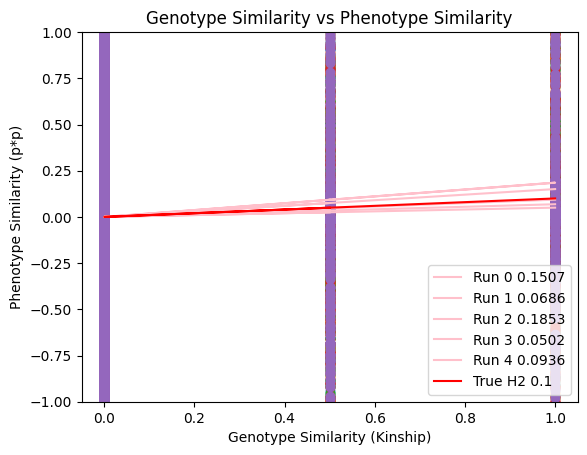

In [12]:
five_runs_per_h2(0.1)

starting new run
starting new run
starting new run
starting new run
starting new run


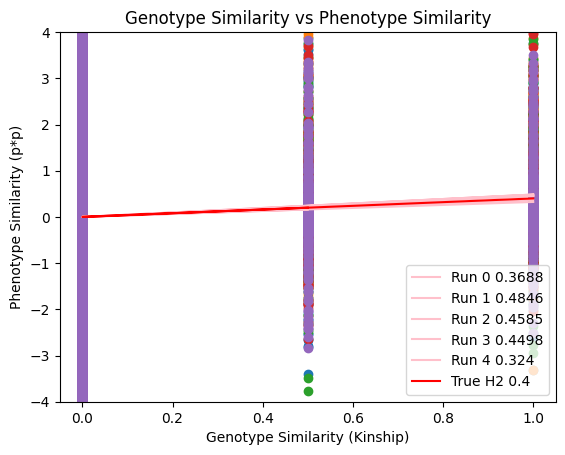

In [13]:
five_runs_per_h2(0.4)

starting new run
starting new run
starting new run
starting new run
starting new run


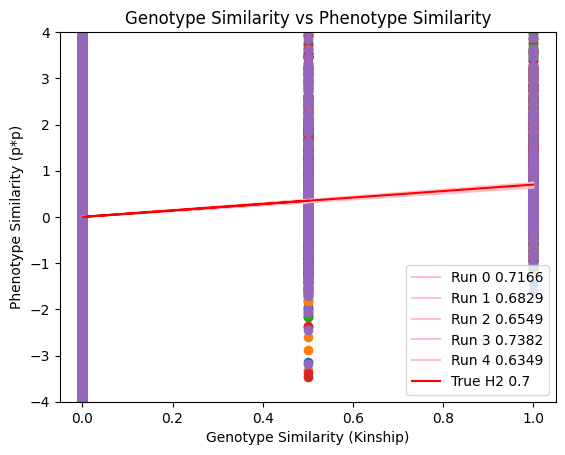

In [16]:
five_runs_per_h2(0.7)

starting new run
starting new run
starting new run
starting new run
starting new run


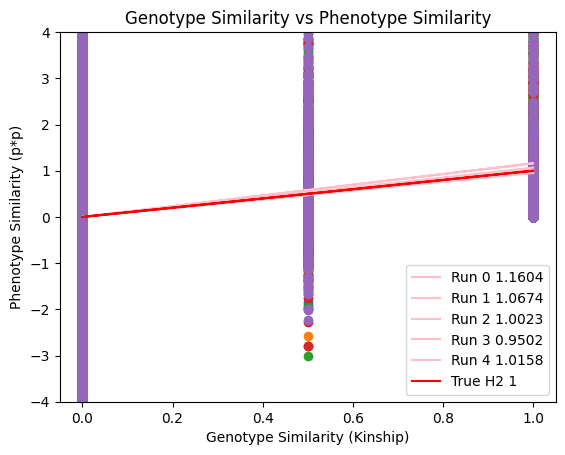

In [17]:
five_runs_per_h2(1)

### Problem 3

#### Step 1

Under the gaussian ACE model, the phenotype of an individual is 
\begin{align*}
y &= A + C + E \\
\end{align*}
where y = phenotype, A = genetic component, C = common environment component, and E = unique environment component.

Assuming that the phenotypes have mean 0 and variance 1, this model allows the expected covariance matrix to be written as 
\begin{align*}
E[yy^T] = \sigma_g^2K + \sigma_e^2I = h^2K + (1-h^2)I \\
\end{align*}
where K is the kinship matrix, I is the identity matrix, $\sigma_g^2$ is genetic variance, $\sigma_e^2$ is environmental variance, and $h^2$ is heritability.

#### Step 2

Falconer's estimate of heritability is
\begin{align*}
 \hat{h} &= 2*(r_{mz} - r_{dz}) = 2*(Cov(mz_1, mz_2) - Cov(dz_1, dz_2))\\
\end{align*}
where MZ = monozygotic twins (K = 1) and DZ = dizygotic twins (K = 0.5).

#### Step 3

Assuming that MZ and DZ twins both share the same amount of common environment, the expected $\sigma_e^2$ is the same, but the $\sigma_g^2$ varies between MZ and DZ twins depending on the amount of shared genetics (MZ twins share their entire genome, DZ twins share half of their genome). Therefore, the expected covariance can be written as
\begin{align*}
E[Cov(mz_1, mz_2)] = \sigma_g^2 + \sigma_e^2 \\
E[Cov(dz_1, dz_2)] = 0.5\sigma_g^2 + \sigma_e^2
\end{align*}

Plugging back into Falconer's estimate of heritability,
\begin{align*}
 \hat{h} &= 2*((\sigma_g^2 + \sigma_e^2) - (0.5*\sigma_g^2 + \sigma_e^2)) &= 2*(0.5\sigma_g^2) = \sigma_g^2\\
\end{align*}

Therefore, the expected value of Falconer's estimate of heritability is 
\begin{align*}
 E[\hat{h}] &= \sigma_g^2 = h^2\\
\end{align*}

Since the expected value of Falconer's estimate of heritability is the heritability, the estimate is unbiased under the ACE model.



